# Autotalker Batch Integration

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 20.01.2023
- **Date of Last Modification:** 26.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")

In [ ]:
import argparse
import os
import pickle
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scib
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [4]:
## Dataset
dataset = "seqfish_mouse_organogenesis"
batch1 = "embryo1_rep1"
batch2 = "embryo1_rep2"
batch3 = "embryo2_rep1"
batch4 = "embryo2_rep2"
batch5 = "embryo3_rep1"
batch6 = "embryo3_rep2"
n_neighbors = 4

## Model
# AnnData Keys
counts_key = "counts"
cell_type_key = "celltype_mapped_refined"
adj_key = "spatial_connectivities"
spatial_key = "spatial"
gp_names_key = "autotalker_gp_names"
active_gp_names_key = "autotalker_active_gp_names"
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
latent_key = "autotalker_latent"
condition_key = "batch"

# Architecture
active_gp_thresh_ratio = 0.03
gene_expr_recon_dist = "nb"
n_cond_embed = 3

# Trainer
n_epochs = 40
n_epochs_all_gps = 20
lr = 0.001
lambda_edge_recon = 0.01 # 0.001
lambda_gene_expr_recon = 0.0033 # 0.00033

## Others
random_seed = 42
load_timestamp = None

### 1.3 Run Notebook Setup

In [5]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [6]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Create Directories

In [7]:
# Define paths
figure_folder_path = f"../figures/{dataset}/batch_integration/{current_timestamp}"
model_artifacts_folder_path = f"../artifacts/{dataset}/batch_integration/{current_timestamp}"
gp_data_folder_path = "../datasets/gp_data" # gene program data
srt_data_folder_path = "../datasets/srt_data" # spatially resolved transcriptomics data
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(model_artifacts_folder_path, exist_ok=True)

## 2. Data

### 2.1 Load Data & Compute Spatial Neighbor Graph

In [8]:
adata_batch1 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch1}.h5ad")
adata_batch2 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch2}.h5ad")
adata_batch3 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch3}.h5ad")
adata_batch4 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch4}.h5ad")
adata_batch5 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch5}.h5ad")
adata_batch6 = ad.read_h5ad(f"{srt_data_gold_folder_path}/{dataset}_{batch6}.h5ad")

adata_batch_list = [adata_batch1,
                    adata_batch2,
                    adata_batch3,
                    adata_batch4,
                    adata_batch5,
                    adata_batch6]

In [9]:
for adata_batch in adata_batch_list:
    # Compute (separate) spatial neighborhood
    sq.gr.spatial_neighbors(adata_batch,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=n_neighbors)
    # Make adjacency matrix symmetric
    adata_batch.obsp["spatial_connectivities"] = adata_batch.obsp["spatial_connectivities"].maximum(
        adata_batch.obsp["spatial_connectivities"].T)

### 2.2 Combine Data for One-Shot Batch Integration

In [10]:
adata_one_shot = ad.concat(adata_batch_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch1.shape[0],
                                                 (adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0] +
                                                  adata_batch5.shape[0] +
                                                  adata_batch6.shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch2.shape[0],
                                                        adata_batch1.shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch2.shape[0],
                                                       (adata_batch3.shape[0] +
                                                        adata_batch4.shape[0] +
                                                        adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch3.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch3.shape[0],
                                                       (adata_batch4.shape[0] +
                                                        adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch4_before = sp.csr_matrix((adata_batch4.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0] +
                                                         adata_batch3.shape[0])))
connectivities_extension_batch4_after = sp.csr_matrix((adata_batch4.shape[0],
                                                       (adata_batch5.shape[0] +
                                                        adata_batch6.shape[0])))
connectivities_extension_batch5_before = sp.csr_matrix((adata_batch5.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0] +
                                                         adata_batch3.shape[0] +
                                                         adata_batch4.shape[0])))
connectivities_extension_batch5_after = sp.csr_matrix((adata_batch5.shape[0],
                                                       adata_batch6.shape[0]))
connectivities_extension_batch6 = sp.csr_matrix((adata_batch6.shape[0],
                                                 (adata_batch1.shape[0] +
                                                  adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0] +
                                                  adata_batch5.shape[0])))

connectivities_batch1 = sp.hstack((adata_batch1.obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch2.obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch3.obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4_before,
                                   adata_batch4.obsp["spatial_connectivities"],
                                   connectivities_extension_batch4_after))
connectivities_batch5 = sp.hstack((connectivities_extension_batch5_before,
                                   adata_batch5.obsp["spatial_connectivities"],
                                   connectivities_extension_batch5_after))
connectivities_batch6 = sp.hstack((connectivities_extension_batch6,
                                   adata_batch6.obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4,
                            connectivities_batch5,
                            connectivities_batch6))

adata_one_shot.obsp["spatial_connectivities"] = connectivities

### 2.3 Combine Data for Query-to-Reference Mapping

In [11]:
adata_reference = ad.concat(adata_batch_list[:-2], join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_batch1 = sp.csr_matrix((adata_batch1.shape[0],
                                                 (adata_batch2.shape[0] +
                                                  adata_batch3.shape[0] +
                                                  adata_batch4.shape[0])))
connectivities_extension_batch2_before = sp.csr_matrix((adata_batch2.shape[0],
                                                        adata_batch1.shape[0]))
connectivities_extension_batch2_after = sp.csr_matrix((adata_batch2.shape[0],
                                                       (adata_batch3.shape[0] +
                                                        adata_batch4.shape[0])))
connectivities_extension_batch3_before = sp.csr_matrix((adata_batch3.shape[0],
                                                        (adata_batch1.shape[0] +
                                                         adata_batch2.shape[0])))
connectivities_extension_batch3_after = sp.csr_matrix((adata_batch3.shape[0],
                                                       (adata_batch4.shape[0])))
connectivities_extension_batch4 = sp.csr_matrix((adata_batch4.shape[0],
                                                 (adata_batch1.shape[0] +
                                                  adata_batch2.shape[0] +
                                                  adata_batch3.shape[0])))

connectivities_batch1 = sp.hstack((adata_batch1.obsp["spatial_connectivities"],
                                   connectivities_extension_batch1))
connectivities_batch2 = sp.hstack((connectivities_extension_batch2_before,
                                   adata_batch2.obsp["spatial_connectivities"],
                                   connectivities_extension_batch2_after))
connectivities_batch3 = sp.hstack((connectivities_extension_batch3_before,
                                   adata_batch3.obsp["spatial_connectivities"],
                                   connectivities_extension_batch3_after))
connectivities_batch4 = sp.hstack((connectivities_extension_batch4,
                                   adata_batch4.obsp["spatial_connectivities"]))

connectivities = sp.vstack((connectivities_batch1,
                            connectivities_batch2,
                            connectivities_batch3,
                            connectivities_batch4))

adata_reference.obsp["spatial_connectivities"] = connectivities

adata_query = adata_batch_list[-1]

In [12]:
adata_reference_query_list = [adata_reference, adata_query]

adata_reference_query = ad.concat(adata_reference_query_list, join="inner")

# Combine spatial neighborhood graphs as disconnected components
connectivities_extension_adata_reference = sp.csr_matrix((adata_reference.shape[0],
                                                          (adata_query.shape[0])))
connectivities_extension_adata_query = sp.csr_matrix((adata_query.shape[0],
                                                      (adata_reference.shape[0])))

connectivities_adata_reference = sp.hstack((adata_reference.obsp["spatial_connectivities"],
                                           connectivities_extension_adata_reference))
connectivities_adata_query = sp.hstack((connectivities_extension_adata_query,
                                       adata_query.obsp["spatial_connectivities"]))

adata_reference_query.obsp["spatial_connectivities"] = sp.vstack((connectivities_adata_reference,
                                                                  connectivities_adata_query))

## 3. Autotalker Model

### 3.1 Prepare Gene Program Mask

In [13]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [14]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [15]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [16]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [17]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [18]:
for adata in [adata_one_shot, adata_reference, adata_query]:

    # Add the gene program dictionary as binary masks to the adata for model training
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_new_gp_dict,
        adata=adata,
        genes_uppercase=True,
        gp_targets_mask_key="autotalker_gp_targets",
        gp_sources_mask_key="autotalker_gp_sources",
        gp_names_key="autotalker_gp_names",
        min_genes_per_gp=1,
        min_source_genes_per_gp=0,
        min_target_genes_per_gp=0,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None,
        filter_genes_not_in_masks=False)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata_one_shot.uns["autotalker_gp_names"])

# Summarize gene programs
print(f"Number of gene programs with probed genes: {len(adata_one_shot.uns['autotalker_gp_names'])}.")
print(f"Example gene programs: {random.sample(list(adata_one_shot.uns['autotalker_gp_names']), 5)}.")
print(f"Number of gene program target genes: {adata_one_shot.varm['autotalker_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata_one_shot.varm['autotalker_gp_sources'].sum()}.")

Number of gene programs with probed genes: 489.
Example gene programs: ['ANGPT2_ligand_targetgenes_GP', 'NPTN_ligand_targetgenes_GP', 'CDH11_ligand_targetgenes_GP', 'IL17A_ligand_targetgenes_GP', 'ESAM_ligand_targetgenes_GP'].
Number of gene program target genes: 7476.
Number of gene program source genes: 127.


### 3.2 One Shot Batch Integration Without Conditional Embedding

#### 3.2.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=None,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/one_shot_no_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.2.2 Load Model

In [19]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

In [20]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_load_folder_path + "/one_shot_no_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 0, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 0, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 0, n_addon_input: 0, n_output: 702


#### 3.2.3 Analyze Latent Space

In [21]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


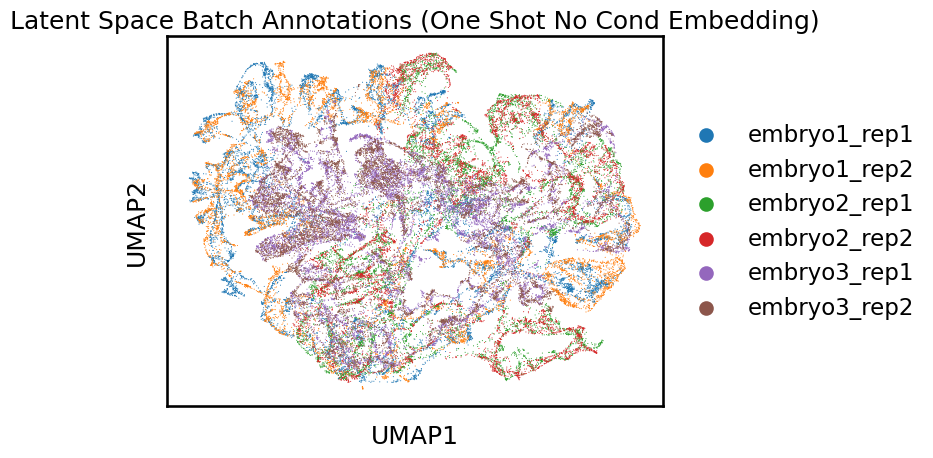

In [22]:
# Plot UMAP with batch annotation
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Latent Space Batch Annotations (One Shot No Cond Embedding)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_batches_one_shot_no_cond_embed.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


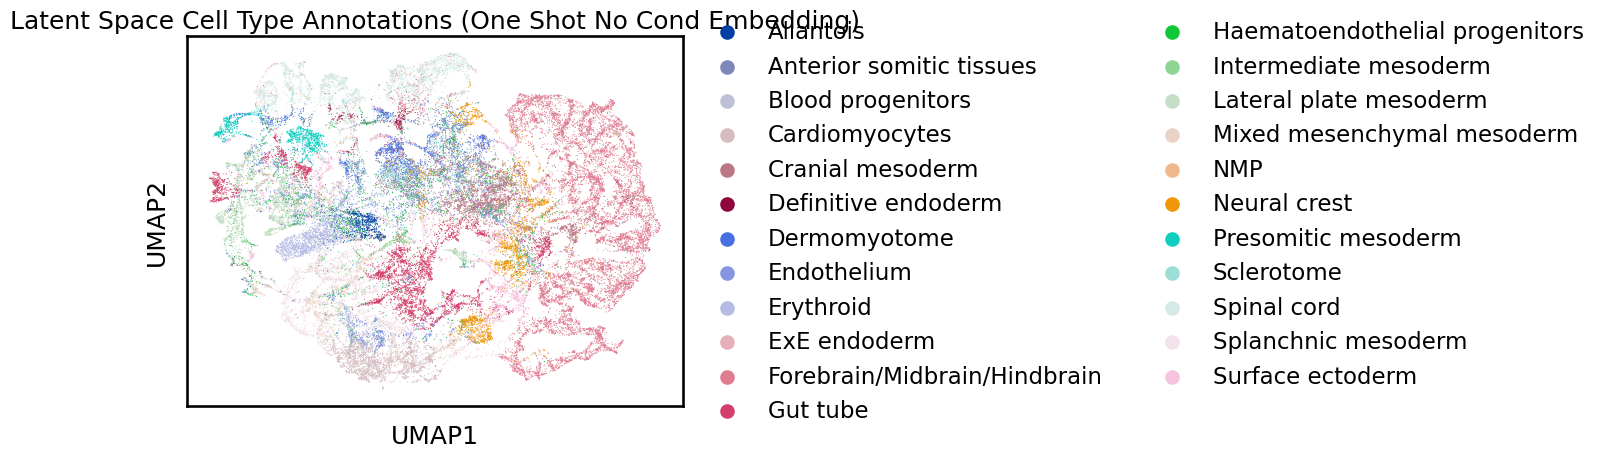

In [23]:
# Plot UMAP with cell type annotation
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Latent Space Cell Type Annotations (One Shot No Cond Embedding)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_cell_types_one_shot_no_cond_embed.png",
            bbox_inches="tight")

#### 3.2.4 Analyze Batch Correction Metrics

In [24]:
batch_correction_metrics_one_shot_no_cond_embed = {}

batch_correction_metrics_one_shot_no_cond_embed["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_one_shot_no_cond_embed)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/batch_correction_metrics_one_shot_no_cond_embed.pickle", "wb") as f:
    pickle.dump(batch_correction_metrics_one_shot_no_cond_embed, f)

Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.904589
Anterior somitic tissues                0.948309
Blood progenitors                       0.897696
Cardiomyocytes                          0.966747
Cranial mesoderm                        0.948330
Definitive endoderm                     0.911697
Dermomyotome                            0.934187
Endothelium                             0.962754
Erythroid                               0.953910
ExE endoderm                            0.858924
Forebrain/Midbrain/Hindbrain            0.978922
Gut tube                                0.944082
Haematoendothelial progenitors          0.965075
Intermediate mesoderm                   0.954167
Lateral plate mesoderm                  0.944706
Mixed mesenchymal mesoderm              0.942681
NMP                                     0.917068
Neural crest                            0.

### 3.3 One-Shot Batch Integration With Conditional Embedding

#### 3.3.1 Initialize, Train & Save Model

In [32]:
# Initialize model
model = Autotalker(adata_one_shot,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"
                   ],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


In [33]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 47311
Number of validation nodes: 5257
Number of training edges: 109836
Number of validation edges: 12204

--- MODEL TRAINING ---
Epoch 1/40 |--------------------| 2.5% val_auroc_score: 0.9229; val_auprc_score: 0.8665; val_best_acc_score: 0.7806; val_best_f1_score: 0.8201; train_kl_reg_loss: 0.0223; train_edge_recon_loss: 0.0462; train_gene_expr_recon_loss: 1.1580; train_group_lasso_reg_loss: 0.0000; train_global_loss: 1.2266; train_optim_loss: 1.2266; val_kl_reg_loss: 0.0169; val_edge_recon_loss: 0.0369; val_gene_expr_recon_loss: 1.0642; val_group_lasso_reg_loss: 0.0000; val_global_loss: 1.1179; val_optim_loss: 1.1179
Epoch 2/40 |█-------------------| 5.0% val_auroc_score: 0.9370; val_auprc_score: 0.8882; val_best_acc_score: 0.7613; val_best_f1_score: 0.8073; train_kl_reg_loss: 0.0250; train_edge_recon_loss: 0.0314; train_gene_expr_recon_loss: 1.0363; train_group_lasso_reg_loss: 0.0000; train_global_loss: 1.0927; train_optim_loss:

In [34]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/one_shot_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

#### 3.3.2 Load Model

In [35]:
if load_timestamp is not None:
    model_artifacts_load_folder_path = f"../artifacts/{dataset}/batch_integration/{load_timestamp}"
else:
    model_artifacts_load_folder_path = model_artifacts_folder_path

In [36]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/one_shot_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['encoder', 'gene_expr_decoder', 'graph_decoder']
GRAPH ENCODER -> n_input: 351, n_cond_embed_input: 3, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> n_cond_embed_input: 3, n_output: 489, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_cond_embed_input: 3, n_addon_input: 0, n_output: 702


#### 3.3.2 Analyze Latent Space

In [37]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


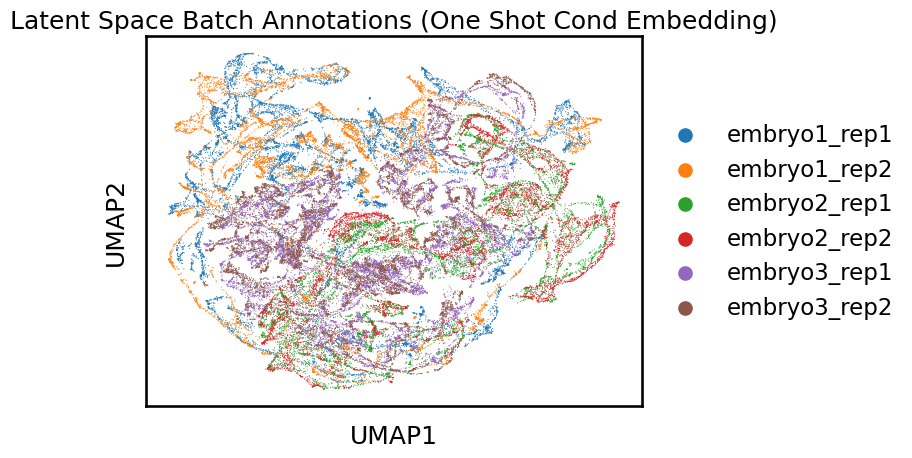

In [38]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Latent Space Batch Annotations (One Shot Cond Embedding)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_batches_one_shot_cond_embed.png",
            bbox_inches="tight")

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


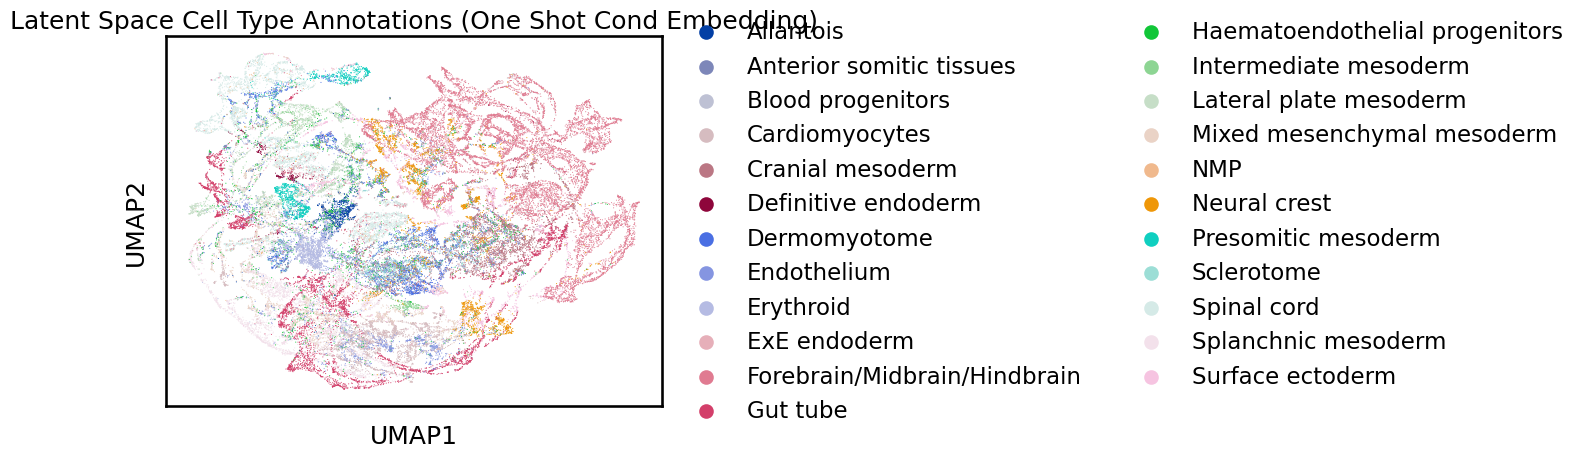

In [39]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Latent Space Cell Type Annotations (One Shot Cond Embedding)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_cell_types_one_shot_cond_embed.png",
            bbox_inches="tight")

#### 3.3.3 Analyze Batch Correction Metrics

In [40]:
batch_correction_metrics_one_shot_cond_embed = {}

batch_correction_metrics_one_shot_cond_embed["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_one_shot_cond_embed)

# Store to disk
with open(f"{model_artifacts_folder_path}"
          "/batch_correction_metrics_one_shot_cond_embed.pickle", "wb") as f:
    pickle.dump(batch_correction_metrics_one_shot_cond_embed, f)

Adding diffusion to step 4


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
Adding diffusion to step 10
Adding diffusion to step 11
Adding diffusion to step 12


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7
Adding diffusion to step 8
Adding diffusion to step 9
Adding diffusion to step 10
Adding diffusion to step 11
Adding diffusion to step 12
Adding diffusion to step 13


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-package

Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


Adding diffusion to step 4
Adding diffusion to step 5


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-package

Adding diffusion to step 4
Adding diffusion to step 5
Adding diffusion to step 6
Adding diffusion to step 7


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:356: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:226: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


mean silhouette per group:                                 silhouette_score
group                                           
Allantois                               0.936100
Anterior somitic tissues                0.960484
Blood progenitors                       0.941059
Cardiomyocytes                          0.966826
Cranial mesoderm                        0.959333
Definitive endoderm                     0.925643
Dermomyotome                            0.949674
Endothelium                             0.974045
Erythroid                               0.965377
ExE endoderm                            0.910573
Forebrain/Midbrain/Hindbrain            0.980180
Gut tube                                0.969247
Haematoendothelial progenitors          0.978689
Intermediate mesoderm                   0.949820
Lateral plate mesoderm                  0.950930
Mixed mesenchymal mesoderm              0.957965
NMP                                     0.939498
Neural crest                            0.

#### 3.3.3 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
cond = model.adata.obs["batch"].unique()

In [ ]:
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=5, kernel='linear')
cond_embed_pca = pca.fit_transform(cond_embed)

import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(
        cond_embed_pca[:, 0], 
        cond_embed_pca[:, 1], 
        cond,
        #hue_order = cond_to_keep,
        #palette = 'Reds',
        ax=ax)

In [ ]:
sc.pp.neighbors(adata_cond_embed)
sc.tl.pca(adata_cond_embed, n_comps=2)
fig = sc.pl.umap(adata_cond_embed,
                 color=[condition_key],
                 size=200,
                 title="One-Shot Conditional Embeddings",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/cond_embed_one_shot.png",
            bbox_inches="tight")

### 3.4 Query-to-Reference Mapping

#### 3.4.1 Reference

##### 3.4.1.1 Initialize, Train & Save Model

In [ ]:
# Initialize model
model = Autotalker(adata_reference,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=["encoder",
                                         "gene_expr_decoder",
                                         "graph_decoder"],
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_hidden_encoder=n_hidden_encoder,
                   n_addon_gps=0,
                   node_label_method="one-hop-attention")

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.1.2 Load Model

In [ ]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

##### 3.4.1.3 Analyze Latent Space

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(model.adata, use_rep=latent_key)
sc.tl.umap(model.adata)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(model.adata,
                 color=[condition_key],
                 title="Latent Space Batch Annotations (Reference Cond Embedding)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_cond_embed.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 color=[cell_type_key],
                 title="Latent Space Cell Type Annotations (Reference Cond Embedding)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_cond_embed.png",
            bbox_inches="tight")

##### 3.4.1.4 Analyze Batch Correction Metrics

In [ ]:
batch_correction_metrics_reference_cond_embed = {}

batch_correction_metrics_reference_cond_embed["graph_connectivity"] = scib.me.graph_connectivity(
    model.adata,
    label_key=cell_type_key)

batch_correction_metrics_reference_cond_embed["ilisi_graph"] = scib.me.ilisi_graph(
    model.adata,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)

batch_correction_metrics_reference_cond_embed["kbet"] = scib.me.kBET(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    type_="embed",
    embed=latent_key)

batch_correction_metrics_reference_cond_embed["silhouette_batch"] = scib.me.silhouette_batch(
    model.adata,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_reference_cond_embed)

##### 3.4.1.5 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
adata_cond_embed = ad.AnnData(cond_embed)
adata_cond_embed.obs["batch"] = model.adata.obs["batch"].unique()

In [ ]:
sc.pp.neighbors(adata_cond_embed)
sc.tl.umap(adata_cond_embed)
fig = sc.pl.umap(adata_cond_embed,
                 color=[condition_key],
                 size=200,
                 title="Reference Conditional Embeddings",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/cond_embed_reference.png",
            bbox_inches="tight")

#### 3.4.2 Query

##### 3.4.2.1 Initialize, Train & Save Model

In [ ]:
# Load model trained on reference data for transfer learning with query data
# Freeze all weights except for conditional weights
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_cond_embed",
                        adata=adata_query,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names",
                        unfreeze_all_weights=False,
                        unfreeze_cond_embed_weights=True)

In [ ]:
# Train model
model.train(n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            verbose=True)

In [ ]:
# Save trained model
model.save(dir_path=model_artifacts_folder_path + "/reference_query_cond_embed",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

##### 3.4.2.2 Load Model

In [ ]:
# Load trained model
model = Autotalker.load(dir_path=model_artifacts_folder_path + "/reference_query_cond_embed",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        gp_names_key="autotalker_gp_names")

##### 3.4.1.3 Analyze Latent Space

In [ ]:
adata_reference_query.uns[gp_names_key] = adata_reference.uns[gp_names_key]

adata_reference_query.obsm["autotalker_latent"] = model.get_latent_representation(
    adata=adata_reference_query,
    condition_key="batch")

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_reference_query, use_rep=latent_key)
sc.tl.umap(adata_reference_query)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[condition_key],
                 title="Latent Space Batch Annotations (Reference Query Mapping Cond Embedding)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_batches_reference_query_cond_embed.png",
            bbox_inches="tight")

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata_reference_query,
                 color=[cell_type_key],
                 title="Latent Space Cell Type Annotations (Reference Query Mapping Cond Embedding)",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_cell_types_reference_query_cond_embed.png",
            bbox_inches="tight")

##### 3.4.2.4 Analyze Batch Correction Metrics

In [ ]:
batch_correction_metrics_reference_query_cond_embed = {}

batch_correction_metrics_reference_query_cond_embed["graph_connectivity"] = scib.me.graph_connectivity(
    adata_reference_query,
    label_key=cell_type_key)

batch_correction_metrics_reference_query_cond_embed["ilisi_graph"] = scib.me.ilisi_graph(
    adata_reference_query,
    batch_key=condition_key,
    type_="embed",
    use_rep=latent_key)

batch_correction_metrics_reference_query_cond_embed["kbet"] = scib.me.kBET(
    adata_reference_query,
    batch_key=condition_key,
    label_key=cell_type_key,
    type_="embed",
    embed=latent_key)

batch_correction_metrics_reference_query_cond_embed["silhouette_batch"] = scib.me.silhouette_batch(
    adata_reference_query,
    batch_key=condition_key,
    label_key=cell_type_key,
    embed=latent_key)

print(batch_correction_metrics_reference_query_cond_embed)

##### 3.4.1.4 Analyze Conditional Embedding

In [ ]:
# Get conditional embeddings
cond_embed = model.get_conditional_embeddings()
adata_cond_embed = ad.AnnData(cond_embed)
adata_cond_embed.obs["batch"] = adata_reference_query.obs["batch"].unique()

In [ ]:
sc.pp.neighbors(adata_cond_embed)
sc.tl.umap(adata_cond_embed)
fig = sc.pl.umap(adata_cond_embed,
                 color=[condition_key],
                 size=200,
                 title="Reference Query Mapping Conditional Embeddings",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/cond_embed_reference_query.png",
            bbox_inches="tight")

In [ ]:
adata_complete = adata_complete[adata_complete.obs["batch"] != "embryo3_rep1"]

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_complete, use_rep=latent_key, key_added=latent_key)
sc.tl.umap(adata_complete, neighbors_key=latent_key)

In [ ]:
# Plot UMAP with batch annotations
fig = sc.pl.umap(adata_complete,
                 color=[condition_key],
                 title="Latent Space with Decoder Integrated Batches: Autotalker",
                 return_fig=True)
fig.savefig(f"{figure_folder_path}/latent_autotalker_batches_integrated_decoder.png",
            bbox_inches="tight")

In [ ]:
scib.me.silhouette_batch(adata=adata_one_shot,
                         batch_key=condition_key,
                         label_key=cell_type_key,
                         embed=latent_key)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_one_shot.obs["condition"] = le.fit_transform(adata_one_shot.obs["batch"].values)

cond_embed = model.get_conditional_embeddings()
active_gp_mask = model.model.get_active_gp_mask()
cond_embed_dot_pr = np.array(model.model.graph_decoder.cond_embed_l(torch.tensor(cond_embed, device="cuda:0"))[:, active_gp_mask].cpu().detach())

In [ ]:
adata_one_shot.obsm["autotalker_latent_cond"] = adata_one_shot.obsm["autotalker_latent"] + cond_embed_dot_pr[torch.tensor(adata_one_shot.obs["condition"].values)]

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_one_shot, use_rep="autotalker_latent_cond")
sc.tl.umap(adata_one_shot)

In [ ]:
fig = sc.pl.umap(adata_one_shot,
                 color=[condition_key],
                 title="Latent Space with Decoder Integrated Batches: Autotalker",
                 return_fig=True)

In [ ]:
# Use Autotalker latent space for UMAP generation
sc.pp.neighbors(adata_one_shot, use_rep=latent_key)
sc.tl.umap(adata_one_shot)

In [ ]:
fig = sc.pl.umap(adata_one_shot,
                 color=[condition_key],
                 title="Latent Space with Decoder Integrated Batches: Autotalker",
                 return_fig=True)